# Importación


In [212]:
import pandas as pd
import numpy as np 
import plotly as ply
import seaborn as sns
import matplotlib.pyplot as plt 
import openai as openai
import keyfile as kf

In [213]:
df_RatedFlights = pd.read_csv('rated_flights.csv')

df_RatedFlights

,Date,Airline,Departure,Arrival,OverallRating,ReportLink
0,19/01/2025,LATAM Brasil,NATNatal Greater Natal International Airport,GRUSao Paulo Guarulhos Int'l,7,../flightlog/report_625375_LATAM Brasil_3443.htm
1,13/01/2025,KLM,BCNBarcelona El Prat,AMSAmsterdam Schiphol,8,../flightlog/report_624841_KLM_1518.htm
2,11/01/2025,Azul Linhas Aereas,SSASalvador Deputado Luís Eduardo Magalhães In...,RECRecife Guararapes - Gilberto Freyre Int'l,10,../flightlog/report_625374_Azul Linhas Aereas_...
3,09/01/2025,Garuda,SINSingapore Changi,CGKJakarta Soekarno - Hatta,9,../flightlog/report_624575_Garuda_839.htm
4,08/01/2025,Azul Linhas Aereas,GRUSao Paulo Guarulhos Int'l,IOSIlheus,10,../flightlog/report_625373_Azul Linhas Aereas_...
...,...,...,...,...,...,...
3095,25/05/2003,DutchBird,LPALas Palmas De Gran Canaria Gando,AMSAmsterdam Schiphol,7,../flightlog/report_221289_DutchBird_902.htm
3096,12/05/2003,DutchBird,AMSAmsterdam Schiphol,LPALas Palmas De Gran Canaria Gando,6,../flightlog/report_221286_DutchBird_901.htm
3097,12/05/2003,DutchBird,LPALas Palmas De Gran Canaria Gando,FORFortaleza Pinto Martins,7,../flightlog/report_221287_DutchBird_901.htm
3098,07/02/2003,IrAero,CGKJakarta Soekarno - Hatta,SUBSurabaya Juanda,7,../flightlog/report_339682_IrAero_200.htm


Los datos presentados corresponden a algunos de los vuelos sucitados entre los años 2002-2024, en el cual se destaca como variable categórica el overall rating el cual ponderiza el rating que las personas le dieron a su experiencia en el check-in, waiting and boarding, in flight y arrival 

Los únicos datos con un componente "subjetivo" son el overall rating y los remarks dentro del reportLink, ya que reflejan la percepción individual de cada experiencia.

# Limpieza

Los datos ingresados manualmente se validan antes de incluirse en el reporte, verificando aerolíneas y ciudades según sus códigos. Además, el formato se asegura automáticamente mediante un formulario con validación en tiempo real

In [214]:
nans= df_RatedFlights.isnull().sum()
print(nans)

#no missing values in the dataset

Date             0
Airline          0
Departure        0
Arrival          0
OverallRating    0
ReportLink       0
dtype: int64


In [215]:
duplicates= df_RatedFlights.duplicated()

print(duplicates.sum())

#no duplicates in the dataset

0


# Exploración

## Análisis de vuelos en el Dataframe

### Existencia de vuelos que partan de una ciudad y regresen a la misma

In [216]:
sameDepArrFlights= df_RatedFlights['Departure'] == df_RatedFlights['Arrival']
print("vuelos de origen y destino igual:",sameDepArrFlights.sum())

vuelos de origen y destino igual: 9


In [217]:
df_RatedFlights[sameDepArrFlights]

,Date,Airline,Departure,Arrival,OverallRating,ReportLink
688,25/05/2022,Sundair,DRSDresden Klotzsche Airport,DRSDresden Klotzsche Airport,10,../flightlog/report_545086_Sundair_1960.htm
701,18/04/2022,Sundair,LEJLeipzig,LEJLeipzig,8,../flightlog/report_542960_Sundair_8796.htm
756,05/02/2022,Air New Zealand,AKLAuckland Auckland International Airport,AKLAuckland Auckland International Airport,10,../flightlog/report_537770_Air New Zealand_601...
760,19/01/2022,Air New Zealand,VCVVictorville George AFB - USA California,VCVVictorville George AFB - USA California,10,../flightlog/report_536960_Air New Zealand_600...
821,16/10/2021,Danish Air Transport,CPHCopenhagen Kastrup,CPHCopenhagen Kastrup,10,../flightlog/report_530715_Danish Air Transpor...
970,07/11/2020,Eurowings,TXLBerlin Tegel,TXLBerlin Tegel,8,../flightlog/report_508926_Eurowings_5237.htm
1735,04/03/2017,Delta Air Lines,ATLAtlanta Hartsfield Jackson International - ...,ATLAtlanta Hartsfield Jackson International - ...,9,../flightlog/report_389510_Delta Air Lines_31.htm
2264,11/11/2014,KLM,AMSAmsterdam Schiphol,AMSAmsterdam Schiphol,10,../flightlog/report_339228_KLM_9895.htm
3031,26/11/2010,KLM,AMSAmsterdam Schiphol,AMSAmsterdam Schiphol,8,../flightlog/report_391038_KLM_803.htm


Se descartan, pues, carecen de confiabilidad

In [218]:
df_RatedFlights.drop(df_RatedFlights[sameDepArrFlights].index, inplace=True)

## Análisis de las aerolineas en el Dataframe

In [219]:
uniqueArilines = df_RatedFlights["Airline"].unique()

print(f"hay {uniqueArilines.size} aerolineas registradas")

hay 313 aerolineas registradas


In [220]:
#convertimos en csv el uniqueArilines
# uniqueArilines.sort()
# df_Airlines = pd.DataFrame(uniqueArilines, columns=['Airline'])
# df_Airlines.to_csv('airlines.csv', index=False)


Obtenemos los paises de los que son cada una de las aerolineas puesto que es una variable que puede influir en el OverallRating

In [221]:
df_Airlines = pd.read_csv('airlines.csv')

df_RatedFlights["Country_Airline"] = df_RatedFlights["Airline"].map(df_Airlines.set_index('Airline')['Country'])

df_RatedFlights

,Date,Airline,Departure,Arrival,OverallRating,ReportLink,Country_Airline
0,19/01/2025,LATAM Brasil,NATNatal Greater Natal International Airport,GRUSao Paulo Guarulhos Int'l,7,../flightlog/report_625375_LATAM Brasil_3443.htm,Brasil
1,13/01/2025,KLM,BCNBarcelona El Prat,AMSAmsterdam Schiphol,8,../flightlog/report_624841_KLM_1518.htm,Países Bajos
2,11/01/2025,Azul Linhas Aereas,SSASalvador Deputado Luís Eduardo Magalhães In...,RECRecife Guararapes - Gilberto Freyre Int'l,10,../flightlog/report_625374_Azul Linhas Aereas_...,Brasil
3,09/01/2025,Garuda,SINSingapore Changi,CGKJakarta Soekarno - Hatta,9,../flightlog/report_624575_Garuda_839.htm,Indonesia
4,08/01/2025,Azul Linhas Aereas,GRUSao Paulo Guarulhos Int'l,IOSIlheus,10,../flightlog/report_625373_Azul Linhas Aereas_...,Brasil
...,...,...,...,...,...,...,...
3095,25/05/2003,DutchBird,LPALas Palmas De Gran Canaria Gando,AMSAmsterdam Schiphol,7,../flightlog/report_221289_DutchBird_902.htm,Países Bajos
3096,12/05/2003,DutchBird,AMSAmsterdam Schiphol,LPALas Palmas De Gran Canaria Gando,6,../flightlog/report_221286_DutchBird_901.htm,Países Bajos
3097,12/05/2003,DutchBird,LPALas Palmas De Gran Canaria Gando,FORFortaleza Pinto Martins,7,../flightlog/report_221287_DutchBird_901.htm,Países Bajos
3098,07/02/2003,IrAero,CGKJakarta Soekarno - Hatta,SUBSurabaya Juanda,7,../flightlog/report_339682_IrAero_200.htm,Rusia


## Ranking de aerolineas por OverallRating

In [222]:
airlinesBYoverallratingCount=df_RatedFlights.groupby('Airline').agg({'OverallRating':'count'}).sort_values(by='OverallRating', ascending=False)


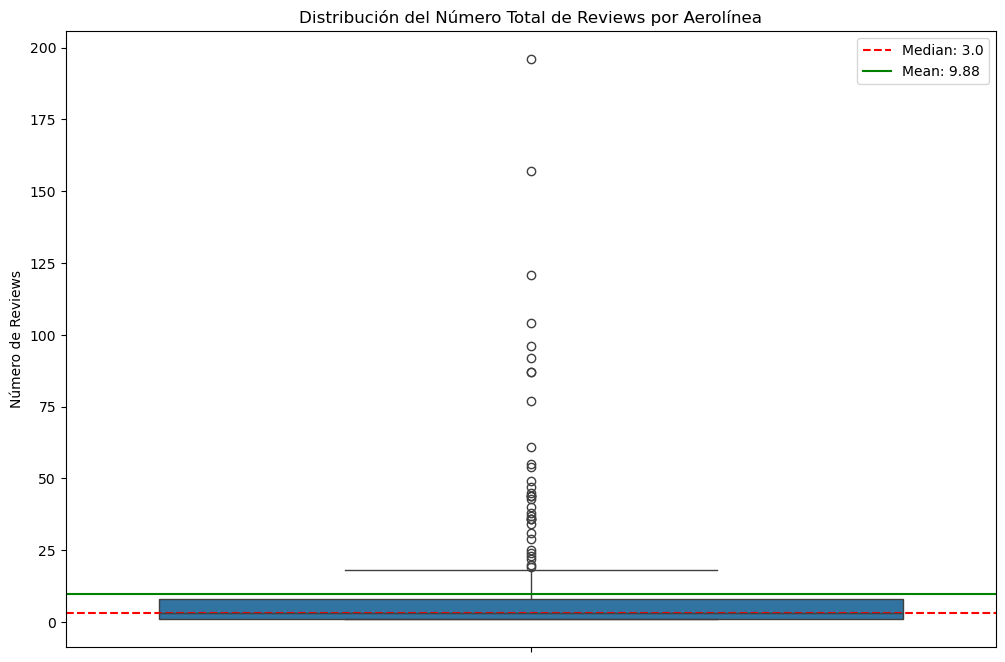

In [223]:


median_value = airlinesBYoverallratingCount['OverallRating'].median()
mean_value = airlinesBYoverallratingCount['OverallRating'].mean()

plt.figure(figsize=(12, 8))
sns.boxplot(data=airlinesBYoverallratingCount, y='OverallRating')
plt.axhline(median_value, color='r', linestyle='--', label=f'Median: {median_value}')
plt.axhline(mean_value, color='g', linestyle='-', label=f'Mean: {mean_value.__round__(2)}')
plt.title('Distribución del Número Total de Reviews por Aerolínea')
plt.ylabel('Número de Reviews')
plt.legend()
plt.show()

In [224]:
airlinesBYoverallratingCount.describe() 

,OverallRating
count,313.000000
mean,9.875399
std,21.475250
min,1.000000
25%,1.000000
50%,3.000000
75%,8.000000
max,196.000000


Se decide descartar las que tengan menos de la media de ratings

In [231]:
airlinesBYoverallratingCount = airlinesBYoverallratingCount[airlinesBYoverallratingCount['OverallRating'] > 3]
df_RatedFlights_airlineBYrating_filtered = df_RatedFlights[df_RatedFlights['Airline'].isin(airlinesBYoverallratingCount.index)]
df_RatedFlights_airlineBYrating_filtered.index = range(df_RatedFlights_airlineBYrating_filtered.shape[0])
df_RatedFlights_airlineBYrating_filtered

,Date,Airline,Departure,Arrival,OverallRating,ReportLink,Country_Airline
0,19/01/2025,LATAM Brasil,NATNatal Greater Natal International Airport,GRUSao Paulo Guarulhos Int'l,7,../flightlog/report_625375_LATAM Brasil_3443.htm,Brasil
1,13/01/2025,KLM,BCNBarcelona El Prat,AMSAmsterdam Schiphol,8,../flightlog/report_624841_KLM_1518.htm,Países Bajos
2,11/01/2025,Azul Linhas Aereas,SSASalvador Deputado Luís Eduardo Magalhães In...,RECRecife Guararapes - Gilberto Freyre Int'l,10,../flightlog/report_625374_Azul Linhas Aereas_...,Brasil
3,09/01/2025,Garuda,SINSingapore Changi,CGKJakarta Soekarno - Hatta,9,../flightlog/report_624575_Garuda_839.htm,Indonesia
4,08/01/2025,Azul Linhas Aereas,GRUSao Paulo Guarulhos Int'l,IOSIlheus,10,../flightlog/report_625373_Azul Linhas Aereas_...,Brasil
...,...,...,...,...,...,...,...
2829,12/08/2003,American Airlines,ORDChicago O'Hare international - Illinois,FRAFrankfurt Frankfurt Main,9,../flightlog/report_159380_American Airlines_8...,Estados Unidos
2830,25/05/2003,DutchBird,FORFortaleza Pinto Martins,LPALas Palmas De Gran Canaria Gando,6,../flightlog/report_221288_DutchBird_902.htm,Países Bajos
2831,25/05/2003,DutchBird,LPALas Palmas De Gran Canaria Gando,AMSAmsterdam Schiphol,7,../flightlog/report_221289_DutchBird_902.htm,Países Bajos
2832,12/05/2003,DutchBird,AMSAmsterdam Schiphol,LPALas Palmas De Gran Canaria Gando,6,../flightlog/report_221286_DutchBird_901.htm,Países Bajos


In [226]:
airlinesBYoverallratingCount
top_30_airlines = airlinesBYoverallratingCount.head(30)
print(top_30_airlines)

                           OverallRating
Airline                                 
Delta Air Lines                      196
Air France                           157
United Airlines                      121
British Airways                      104
Lufthansa                             96
Ryanair                               92
KLM                                   87
Vueling Airlines                      87
American Airlines                     77
THY Turkish Airlines                  61
Aeromexico                            55
Qatar Airways                         54
Aeromexico Connect                    49
LATAM Brasil                          47
Cathay Pacific                        45
Aeroflot                              44
SAS Scandinavian Airlines             44
Alitalia                              44
Emirates                              43
Southwest Airlines                    40
EasyJet                               38
Iberia                                37
GOL Transportes 

In [227]:
df_flights_all_years = pd.read_csv('flights_all_years.csv')

df_flights_all_years

,Year,Date,Flights
0,2025 Number of flights,2024-12-31,156956
1,2025 Number of flights,2025-01-01,205823
2,2025 Number of flights,2025-01-02,213193
3,2025 Number of flights,2025-01-03,198500
4,2025 Number of flights,2025-01-04,186594
...,...,...,...
2951,2021 7-day moving average,2025-12-26,155327
2952,2021 7-day moving average,2025-12-27,150982
2953,2021 7-day moving average,2025-12-28,145823
2954,2021 7-day moving average,2025-12-29,141828


In [228]:

key = kf.getKey()
openai.api_key = key

prompt = "necesito "
